In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *
import h5py
from sklearn.preprocessing import OneHotEncoder
from cbrain.climate_invariant import *
import yaml
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


## DataGenerator

In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/DFS-L/DATA/pritchard/ankitesg/data/CESM2_f19_v13_updated_NN_pelayout01_ens_07.cam.h1.2003-01-22-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
DATA_DIR = '/DFS-L/DATA/pritchard/ankitesg/datav3/'
hyam = coor.hyam
hybm = coor.hybm
scale_dict = load_pickle('/export/nfs0home/ankitesg/tom/CBRAIN-CAM/nn_config/scale_dicts/2020_10_16_scale_dict_RG.pkl')['scale_dict_RG']

In [3]:
scale_dict

{'PHQ': array([7.0811688e+07, 1.3074195e+08, 2.1416968e+08, 3.0895507e+08,
        3.8762448e+08, 4.4520454e+08, 4.4321338e+08, 3.6317286e+08,
        4.2725360e+08, 5.0264170e+08, 5.9133267e+08, 6.9567149e+08,
        8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
        1.5677202e+09, 1.8443410e+09, 2.1697718e+09, 2.1706406e+09,
        1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
        6.7863757e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
        4.4820157e+08, 3.7970438e+08], dtype=float32),
 'PHCLDLIQ': array([7.0811688e+07, 1.3074195e+08, 2.1416968e+08, 3.0895507e+08,
        3.8762448e+08, 4.4520454e+08, 4.4321338e+08, 3.6317286e+08,
        4.2725360e+08, 5.0264170e+08, 5.9133267e+08, 6.9567149e+08,
        8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
        1.5677202e+09, 1.8443410e+09, 2.1697718e+09, 2.1706406e+09,
        1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
        6.7863757e+08, 6.2842387e+08, 5.73

In [4]:
scale_dict['CLDICEBCTEND'] = scale_dict['CLDICEBCTEND'] * np.sqrt(10)

In [5]:
scale_dict['CLDICEBCTEND']

array([2.1785229e+08, 4.0222800e+08, 6.5889331e+08, 9.5050144e+08,
       1.1925274e+09, 1.3696736e+09, 1.3635465e+09, 1.0742467e+09,
       1.2637970e+09, 1.4867904e+09, 1.7491331e+09, 2.0577654e+09,
       2.4208492e+09, 2.8480118e+09, 3.3505344e+09, 3.9417272e+09,
       4.6372393e+09, 5.4554701e+09, 6.4180833e+09, 7.5505418e+09,
       7.3801180e+09, 6.7182894e+09, 5.6048128e+09, 4.0863534e+09,
       2.2576755e+09, 1.1581482e+09], dtype=float32)

In [4]:
class DataGeneratorClimInvRealGeo(DataGenerator):

    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train', exp=None):
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.exp = exp
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div


    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        return X_norm, Y

In [5]:
in_vars = ['QBP','TBP','CLDLIQBP','CLDICEBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND', 'CLDICEBCTEND', 'NN2L_FLWDS', 'NN2L_PRECC', 
            'NN2L_PRECSC', 'NN2L_SOLL', 'NN2L_SOLLD', 'NN2L_SOLS', 'NN2L_SOLSD', 'NN2L_NETSW']

In [6]:
TRAINFILE = 'RG_SP_M4K_train_shuffle.nc'
NORMFILE = 'RG_SP_M4K_NORM_norm.nc'
VALIDFILE = 'RG_SP_M4K_valid.nc'

In [7]:
train_gen_bf = DataGeneratorClimInv(
    data_fn = f'{DATA_DIR}{TRAINFILE}',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f'{DATA_DIR}{NORMFILE}',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


In [8]:
valid_gen_bf = DataGeneratorClimInv(
    data_fn = f'{DATA_DIR}{VALIDFILE}',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f'{DATA_DIR}{NORMFILE}',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


In [10]:
train_gen_bf.n_batches

42120

In [11]:
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
model = tf.keras.models.load_model(f'{path_HDF5}/BF_RGV7_retrain.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               20928     
_________________________________________________________________
dense_1 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_2 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_3 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_4 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_5 (Dense)              (None, 112)               21616     
Total params: 190,768
Trainable params: 190,768
Non-trainable params: 0
__________________________________________________

In [61]:
f = h5py.File(f'{path_HDF5}/BF_RGV5.h5','r')

In [62]:
model_weights = f['model_weights']

In [66]:
list(model_weights['dense_29'].keys())

['dense_29']

In [63]:
model_config = f.attrs['model_config'].decode('utf-8')
model_config = model_config.replace('true','True')
model_config = model_config.replace('false','False')
model_config = model_config.replace('null','None')
# convert to dictionary
model_config = eval(model_config)

In [64]:
 model_config['config']['layers']

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': [None, 108],
   'dtype': 'float32',
   'sparse': False,
   'ragged': False,
   'name': 'input_4'}},
 {'class_name': 'Dense',
  'config': {'name': 'dense_29',
   'trainable': True,
   'dtype': 'float32',
   'units': 128,
   'activation': 'linear',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'GlorotUniform',
    'config': {'seed': None, 'dtype': 'float32'}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}},
 {'class_name': 'LeakyReLU',
  'config': {'name': 'leaky_re_lu_26',
   'trainable': True,
   'dtype': 'float32',
   'alpha': 0.30000001192092896}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_5',
   'trainable': True,
   'dtype': 'float32',
   'rate': 0.2,
   'noise_shape': None,
   'seed': None}},
 {'class_name'

## Brute Force Network

**custom Loss**

In [12]:
import tensorflow.keras.backend as K


In [ ]:
def weighted_mse(y_true,y_pred):
    wmse = K.cast(0.0,'float')

    size = K.shape(y_true)[0]
    for i in range(0,K.eval(size)):
        wmse += 1/(i+1)*K.square((y_true[i]-y_pred)[i])

    wmse /= K.eval(size)
    return wmse

In [9]:
model = Sequential()
model.add(Input(shape=(108,)))
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2))
for i in range (4):
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.3))
    
for i in range (3):
    model.add(Dense(256, activation='linear'))
    model.add(LeakyReLU(alpha=0.3))
    
model.add(Dense(112, activation='linear'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               13952     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

In [28]:
model.compile(optimizer=opt, loss='mse')

In [29]:
# model.compile(tf.keras.optimizers.Adam(), loss="mse")
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'BF_RGV5.h5',save_best_only=True, monitor='val_loss', mode='min')

In [30]:
with tf.device('/gpu:0'):
    Nep = 15
    model.fit_generator(train_gen_bf, epochs=Nep, validation_data=valid_gen_bf,\
                  callbacks=[earlyStopping, mcp_save])

Epoch 1/15
42120/42120 [==============================] - 587s 14ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 242.2194 - val_loss: 210.1939
Epoch 2/15
42120/42120 [==============================] - 694s 16ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 213.8643 - val_loss: 238.4301
Epoch 3/15
42120/42120 [==============================] - 536s 13ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 207.6300 - val_loss: 237.8007
Epoch 4/15
42120/42120 [==============================] - 519s 12ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 204.3374 - val_loss: 251.5929
Epoch 5/15
42120/42120 [==============================] - 516s 12ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 202.0122 - val_loss: 259.2590
Epoch 6/15
42120/42120 [==============================] - 518s 12ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 200.2397 - val_loss: 252.3907
Epoch 7/15
42120/42120 [==============================] - 499s 12ms/step - batch: 21059.5000 - size: 1024.

KeyboardInterrupt: 

## Model Diagnostics

In [7]:
config_file = 'CI_RG_M4K_CONFIG.yml' # Configuration file
data_file = ['RG_SP_M4K_valid.nc']  # Validation/test data sets
NNarray = ['BF_RGV3.h5'] # NN to evaluate 
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
NNname = ['BF'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [8]:
# Indices of different variables
PHQ_idx = slice(0,26)
TPHYSTND_idx = slice(26,52)

In [9]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    model = path
    exp=None

    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                     '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=None, inp_divRH=None,
                                     inp_subTNS=None,inp_divTNS=None,
                                     model=model,exp=exp)
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                                '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                              nlat=96,nlon=144,nlev=26)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  BF_RGV3.h5
data name is  RG_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:998: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [10]:
mdx =  md['BF_RGV3.h5'][data_file[0][6:-3]] 
mdx.compute_stats(niter=48)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.



/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:177: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:183: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [11]:
tendencies = out_vars[:4]

In [12]:
mdx.stats['mse'].shape

(96, 144, 112)

In [31]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    


In [34]:
def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
#     ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

**Assumptions**

The values are calculated for 48 timesteps. This is run on validation dataset. We have total `lat` dimension of `96` and total `lon` of `144` and a `lev` dimension of `26`. The datapoints are selected sequentially in a non random fashion

**MSE**

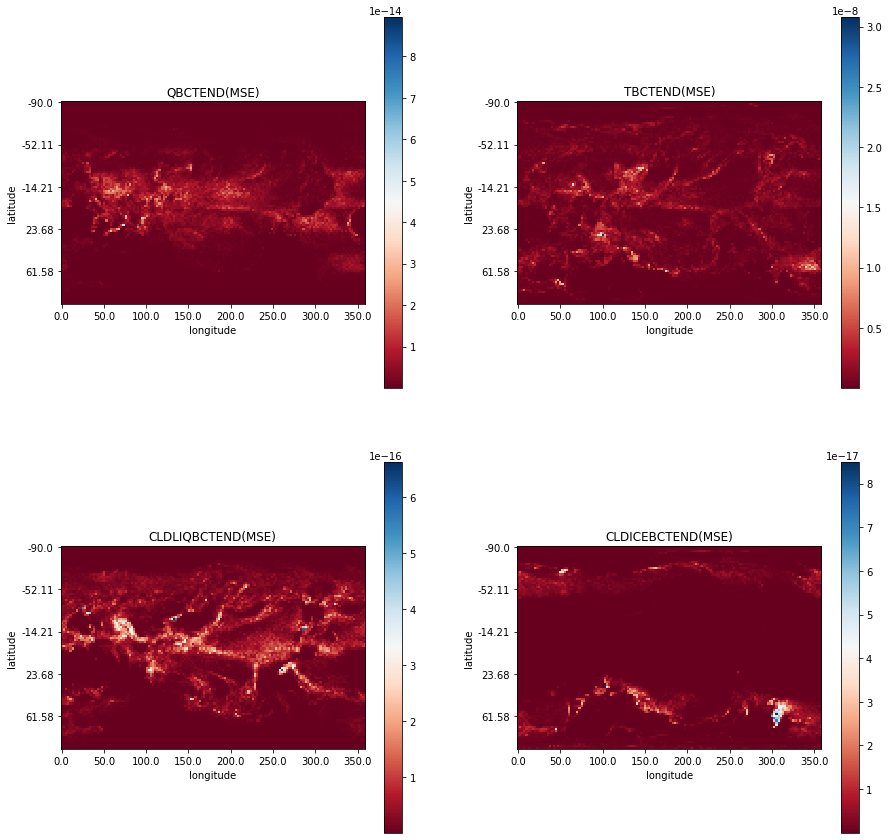

In [43]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
for i,t in enumerate(tendencies):
    im = axarr[i].imshow(mdx.stats['mse'][:,:,(i+1)*25],cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("longitude")
    axarr[i].set_ylabel("latitude")
    axarr[i].set_title(f"{t}(MSE)")
    axarr[i].set_xticks(np.arange(0,141,20))
    f.colorbar(im,ax=axarr[i])
    axarr[i].set_xticklabels(x_ticks)
    axarr[i].set_yticks(np.arange(0,81,20))
    axarr[i].set_yticklabels(y_ticks)
    

**BIAS**

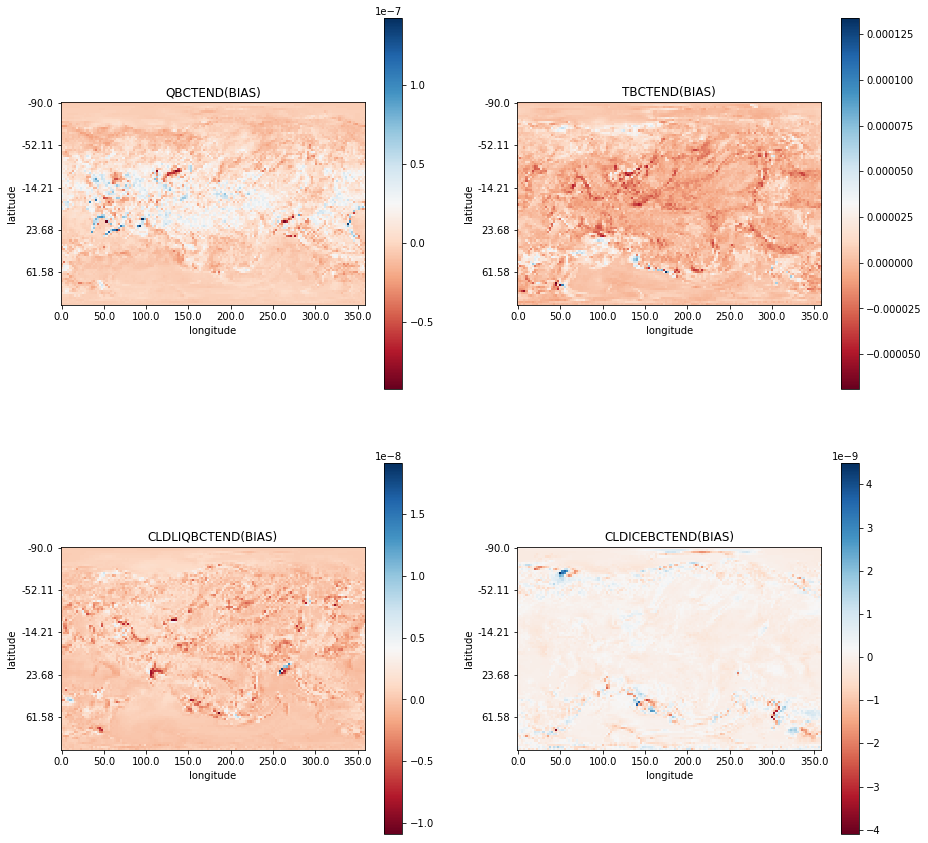

In [44]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
for i,t in enumerate(tendencies):
    im = axarr[i].imshow(mdx.stats['bias'][:,:,(i+1)*25],cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("longitude")
    axarr[i].set_ylabel("latitude")
    axarr[i].set_title(f"{t}(BIAS)")
    f.colorbar(im,ax=axarr[i])
    axarr[i].set_xticks(np.arange(0,141,20))
    axarr[i].set_xticklabels(x_ticks)
    axarr[i].set_yticks(np.arange(0,81,20))
    axarr[i].set_yticklabels(y_ticks)


**Mean along longitude**

**MSE**

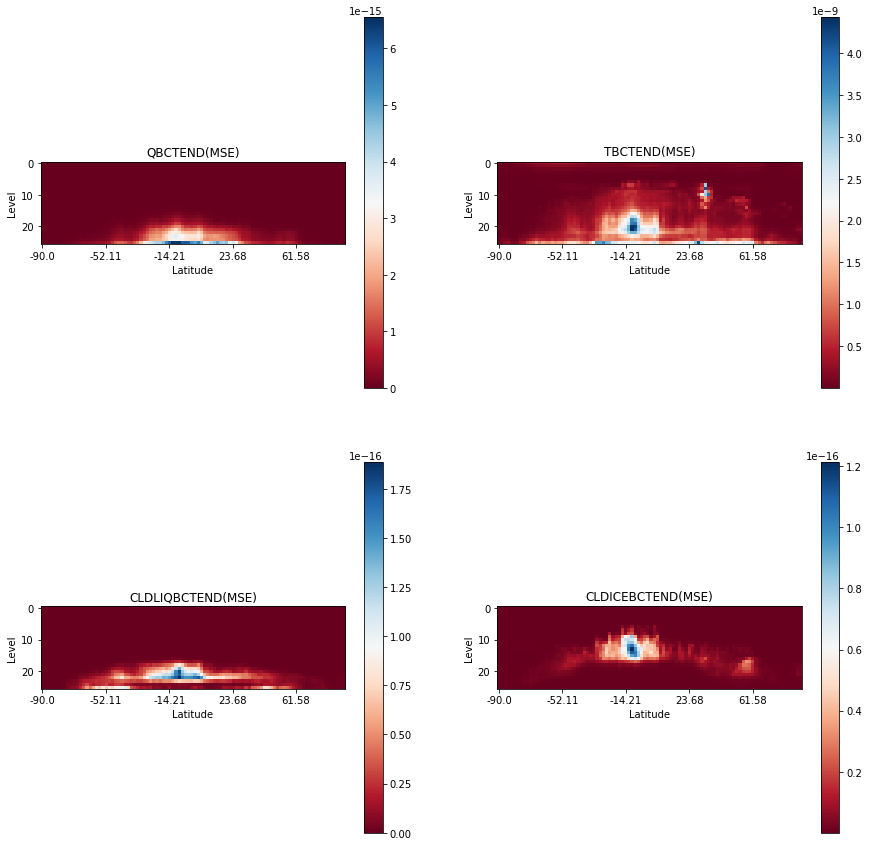

In [45]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
lon_mean = np.mean(mdx.stats['mse'],axis=1)
for i,t in enumerate(tendencies):
    im = axarr[i].imshow(lon_mean[:,i*26:(i+1)*26].T,cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("Latitude")
    axarr[i].set_ylabel("Level")
    axarr[i].set_title(f"{t}(MSE)")
    f.colorbar(im,ax=axarr[i])
    axarr[i].set_xticks(np.arange(0,81,20))
    axarr[i].set_xticklabels(y_ticks)

**BIAS**

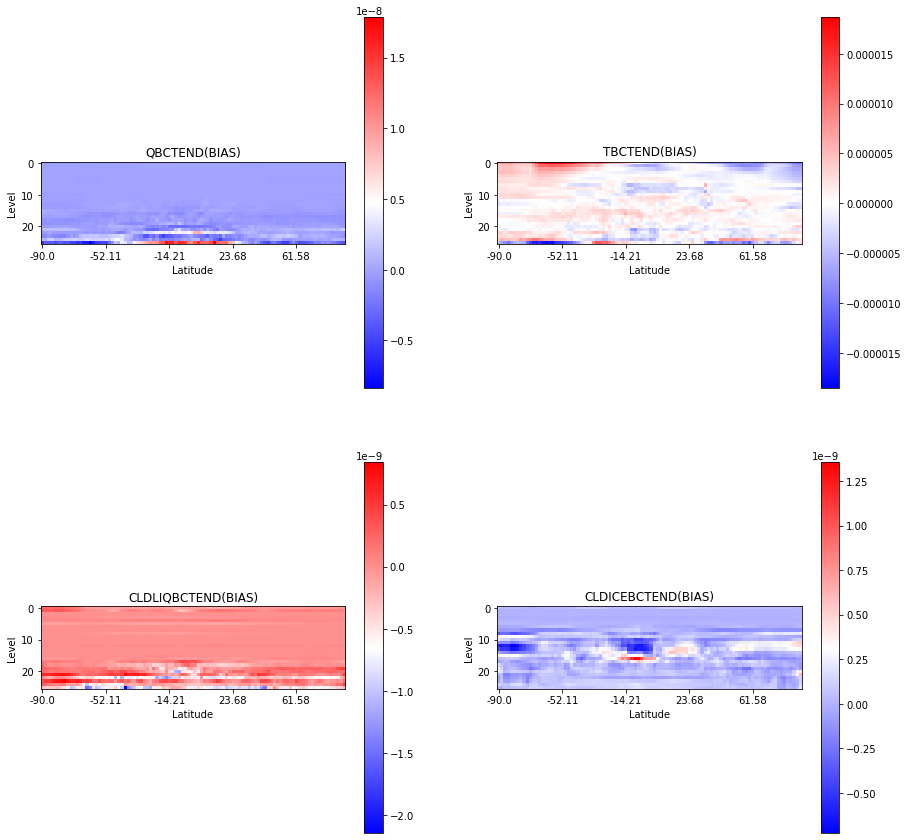

In [56]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
lon_mean = np.mean(mdx.stats['bias'],axis=1)
for i,t in enumerate(tendencies):
    im = axarr[i].imshow(lon_mean[:,i*26:(i+1)*26].T,cmap=plt.cm.bwr)
    axarr[i].set_xlabel("Latitude")
    axarr[i].set_ylabel("Level")
    axarr[i].set_title(f"{t}(BIAS)")
    f.colorbar(im,ax=axarr[i])
    axarr[i].set_xticks(np.arange(0,81,20))
    axarr[i].set_xticklabels(y_ticks)

## Tuning 

In [9]:
from kerastuner import HyperModel

from kerastuner.tuners import RandomSearch

In [49]:
class RGModel(HyperModel):
    def __init__(self, n_hidden):
        self.n_hidden = n_hidden
        
    def build(self, hp):   
        model = Sequential()
        model.add(Input(shape=(108,)))
        model.add(Dense(units=hp.Int(
                            'units',
                            min_value=32,
                            max_value=512,
                            step=32,
                            default=128
                        ),
                        activation=hp.Choice(
                            'dense_activation',
                            values=['relu', 'tanh', 'sigmoid'],
                            default='relu'
                        )
                    )
        )
        # model.add(LeakyReLU(alpha=0.3))
        for i in range (4):
            model.add(Dense(units=hp.Int(
                            'units',
                            min_value=32,
                            max_value=512,
                            step=32,
                            default=128
                        ),
                        activation=hp.Choice(
                            'dense_activation',
                            values=['relu', 'tanh', 'sigmoid'],
                            default='relu'
                        )
                    )
        )   

        model.add(Dense(112, activation='linear'))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='mse',
            metrics=['mse']
        )
        return model

In [50]:
hypermodel = RGModel(n_hidden=2)

In [51]:
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

In [52]:
tuner = RandomSearch(
    hypermodel,
    objective='val_mean_squared_error',
    seed=1,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='RGBFV6'
)

INFO:tensorflow:Reloading Oracle from existing project random_search/RGBFV6/oracle.json
INFO:tensorflow:Reloading Tuner from random_search/RGBFV6/tuner0.json


In [53]:
tuner.search_space_summary()

In [54]:
N_EPOCH_SEARCH = 1
# train_generator, steps_per_epoch=200, epochs=60, validation_data=validation_generator
tuner.search(train_gen_bf, epochs=N_EPOCH_SEARCH, validation_data=valid_gen_bf,verbose=0)

KeyboardInterrupt: 

In [44]:
tuner.results_summary()

In [45]:
best_model = tuner.get_best_models(num_models=1)[0]

In [47]:
best_model.save('/DFS-L/DATA/pritchard/ankitesg/models/BFv10.h5')

## Loading Best Model

In [12]:
model = Sequential()
model.add(Input(shape=(108,)))
model.add(Dense(units=320)
)
model.add(LeakyReLU(alpha=0.3))
for i in range (4):
    model.add(Dense(units=320))
    model.add(LeakyReLU(alpha=0.3))

model.add(Dense(112, activation='linear'))

In [10]:
model.load_weights('/export/nfs0home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/random_search/RGBFV7/trial_6b5d276ab59b592ced1a9f36fc78cf13/checkpoints/epoch_0/checkpoint')

In [13]:
opt = tf.keras.optimizers.Adam()

In [14]:
model.compile(optimizer=opt, loss='mse')

In [15]:
# model.compile(tf.keras.optimizers.Adam(), loss="mse")
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'BF_RGV11.h5',save_best_only=True, monitor='val_loss', mode='min')

In [16]:
with tf.device('/gpu:1'):
    Nep = 15
    model.fit_generator(train_gen_bf, epochs=Nep, validation_data=valid_gen_bf
                        ,callbacks=[earlyStopping, mcp_save])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
42116/42120 [============================>.] - ETA: 0s - batch: 21057.5000 - size: 1024.0000 - loss: 230.9815WARNING:tensorflow:From /export/home/ankitesg/anaconda3/envs/CBrainEnv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
42120/42120 [==============================] - 598s 14ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 230.9792 - val_loss: 207.2354
Epoch 2/15
42120/42120 [==============================] - 595s 14ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 195.9752 - val_loss: 196.4284
Epoch 3/15
42120/42120 [==============================] - 594s 14ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 188.4831

In [23]:
from tqdm.keras import TqdmCallback

In [31]:
model.save(f'{path_HDF5}/RGBFV7_reloaded.h5')